<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_10_INCOMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICS ML Lesson 10: introduction to Gaussian regression

Welcome to Lesson 10 of the North Carolina Institute for Climate Studies' Machine Learning Course. In this session, we'll examine how to use support vector machines for regression problems.  We'll be using a new~ish data set (we introduced it in the last lesson); this set is derived from the US Climate Reference Network.

## About the data set:

Check the USCRN_Daily_Data_readme.txt file in the repository for a complete description of this dataset.

# Preprocess the data

We will be using a new data set from the US Climate Reference Network's Asheville station. Let's load and preprocess it.

In [ ]:
# Import all of the libraries that we'll be using.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

# Import additional modules, objects, and functions that we'll use.
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


# Define the path and names of our data files.
path_data_dir =\
  "./ML4ES-tutorials/00-Data/USCRN-data/"
filename_data = "USCRN-NC_Asheville_8_SSW_2001-2019.csv"

# Clone the data from the GitHub repo and then check which files are present.
try:
    ! git clone https://github.com/geo-yrao/ML4ES-tutorials.git
    ! ls $path_data_dir
except:
    ! ls $path_data_dir

fatal: destination path 'ML4ES-tutorials' already exists and is not an empty directory.
README.md		     USCRN-NC_Asheville_8_SSW_2001-2019.csv
USCRN_Daily_Data_readme.txt  USCRN-NC_Asheville_8_SSW_2010-2019.csv


## Ingest the data 

We will ingest the data and keep the following fields as our features: T_DAILY_AVG, P_DAILY_CALC, SOLARAD_DAILY, SUR_TEMP_DAILY_AVG, RH_DAILY_AVG.

We will be using the 10 cm soil depth as our regression target for this case (we used 20 cm in the last lesson). Note that I've commented out the other depths. You can play with those later if you're interested.

In [ ]:
# Use pandas's read_csv() function to import the data. Stipulate that the first
# column as the dataframe's index.
df = pd.read_csv(path_data_dir+filename_data, index_col="LST_DATE")


# Subset to columns-of-interest and use dates as dataframe index.
cols_to_keep_data = [
    "T_DAILY_AVG", "P_DAILY_CALC", "SOLARAD_DAILY",
    "SUR_TEMP_DAILY_AVG", "RH_DAILY_AVG"
]
cols_to_keep_soil_moisture = [
    # "SOIL_MOISTURE_5_DAILY",
    "SOIL_MOISTURE_10_DAILY",
    # "SOIL_MOISTURE_20_DAILY"
]
df_data = df[cols_to_keep_data]
df_soil_moisture = df[cols_to_keep_soil_moisture]

# Get rid of rows with NaN values.
df_data = df_data.dropna()
df_soil_moisture = df_soil_moisture.loc[df_data.index]

df_soil_moisture = df_soil_moisture.dropna()
df_data = df_data.loc[df_soil_moisture.index]

# Reindex the dataframe using the dates converted into datetime objects.
dates_list = [datetime.strptime(str(d),'%Y%m%d') for d in df_data.index]
df_data.index = dates_list
df_soil_moisture.index = dates_list

In [ ]:
df_soil_moisture

,SOIL_MOISTURE_10_DAILY
2010-01-20,0.329
2010-01-21,0.359
2010-01-22,0.370
2010-01-23,0.341
2010-01-24,0.387
...,...
2019-05-13,0.241
2019-05-14,0.227
2019-05-15,0.218
2019-05-16,0.203


## Explore USCRN Asheville station data

We will explore the USCRN soil moisture data by plotting the features and target. We will then calculate the correlation values between both features and the soil moisture targets. These correlations will give us an idea of which features may hold more information regarding concurrent soil moisture values.

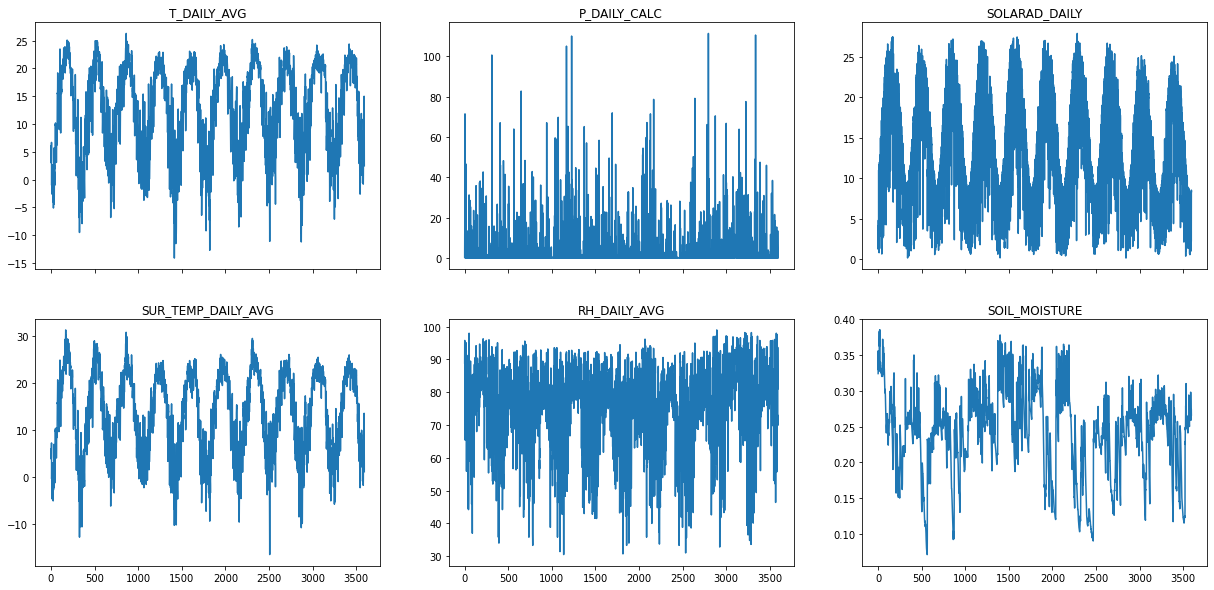

In [ ]:
# Make a quick plot of all the features to gain some understanding as to their characteristics.
fig, ax = plt.subplots(2, 3, figsize=(21, 10), sharex=True)
x = [i for i in range(1, df_data.shape[0]+1)]
for i in range(2):
    for j in range(3):
        idx = i*3+j
        current_ax = ax[i,j]
        if idx==5:
            current_ax.plot(df_soil_moisture.values)
            current_ax.set_title("SOIL_MOISTURE")
            continue
        current_ax.plot(x, df_data.values[:, idx])
        current_ax.set_title(df_data.columns[idx])

Text(0.5, 1.0, 'Feature correlations')

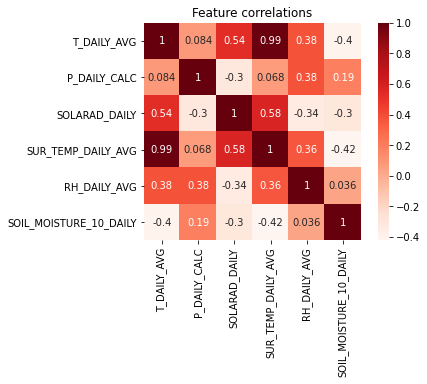

In [ ]:
# Combine the feature and target dataframes so as to easily calculate their
# correlation coefficients.
df_combined = pd.concat([df_data, df_soil_moisture], axis=1)

# Calculate the correlations matrix between the variables.
correlations_matrix = np.corrcoef(df_combined.values.T)
combined_cols_list = df_data.columns.to_list() + df_soil_moisture.columns.to_list()

# Plot the correlation matrix.
ax = seaborn.heatmap(
    correlations_matrix, cmap="Reds", annot=True, square=True, cbar=True,
    xticklabels=combined_cols_list, yticklabels=combined_cols_list,
)
ax.set_title("Feature correlations")

# Introduce a one-day time lag to the data

We know that there is most likely a time delay between a relevant input to the soil moisture system and the resulting soil moisture value; ie, it probably takes a few hours (or perhaps even longer) for a rainfall event to create a visible effect at different depths, or for a hot day to cause the top soil layers to lose moisture content.

Thus, let's play with introducing a simple time delay into the data, in single day increments. 

Douglas and I will set it up so you all can play with the time delay.

In [ ]:
# Define the number of days to lag the data.
n_days = -1

# Shift the soil moisture data forward by that number of days. Now, each day has 
# the soil moisture from n_days ago assigned to it. So, if n_days=1 and we're 
# looking at today's data, the soil moisture value is actually from yesterday.
df_soil_moisture_lagged = df_soil_moisture.shift(periods=n_days).iloc[:n_days]
df_data_lagged = df_data.iloc[:n_days]
df_combined_lagged = pd.concat([df_data_lagged, df_soil_moisture_lagged], axis=1)

# Train the Gaussian Process Regressor (GPR) and find the best hyperparameters

Now it's time to train our training GPR! We're going to vary the length scales that the kernel considers. That length scale we're referring to we will call sigma (that's its usual name). 

**Use the following code to try and build the best-fitting GPR possible.**

Here, because of the temporal nature of the data, we're introducing the concept of leave-one-out cross validation (just like last time).  The idea is to prevent any data leak from the training set to the test set by temporally separating them as best as possible. We'll explore this concept more in upcoming notebooks.

In [ ]:
# Make a list of unique years.
years_list = [d.year for d in df_data.index]
unique_years_list = list(set(years_list))
unique_years_list.sort()

# Define a training year and then split the data into training and testing.
fig, ax = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(21, 5))
sigmas = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28]

# Use the following fig, ax properties if you want to model the entire dataset.
# fig, ax = plt.subplots(5, 2, sharex=True, sharey=False, figsize=(14, 25))
# kernels = [
#         1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
#         1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
#         1.0 * ExpSineSquared(
#             length_scale=1.0, periodicity=3.0,
#             length_scale_bounds=(0.1, 10.0),
#             periodicity_bounds=(1.0, 10.0)
#         ),
#         ConstantKernel(0.1, (0.01, 10.0))
#             * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
#             1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
#                         nu=1.5
#         )
# ]

for sigma in sigmas:
# for kernel in kernels:
    for idx, year in enumerate(unique_years_list[:2]):
        train_idxs_list = [False if y==year else True for y in years_list][:n_days]
        test_idxs_list = [True if y==year else False for y in years_list][:n_days]
        X_train = df_data_lagged.loc[train_idxs_list].values
        y_train = df_soil_moisture_lagged.loc[train_idxs_list].values
        X_test = df_data_lagged.loc[test_idxs_list].values
        y_test = df_soil_moisture_lagged.loc[test_idxs_list].values

        # Make an sklearn.pipeline object that includes a standard scaler (SVMs don't do 
        # well unless their data are scaled) and a support vector regressor.
        clf = make_pipeline(
            StandardScaler(),
            GaussianProcessRegressor(
                kernel=RBF(length_scale=sigma)),
                # kernel=kernel,
                random_state=7, 
                normalize_y=True
            )
        )

        # Train the regressor.
        clf.fit(X_train, y_train.ravel())

        # Plot the actual soil moisture and predicted soil moisture of the test year.
        x = [i for i in range(len(y_test))]
        # i = idx % 5
        # j = idx // 5
        # current_ax = ax[i, j]
        
        # current_ax = ax[i]
        current_ax.plot(x, y_test, label="Ground truth")
        current_ax.plot(x, clf.predict(X_test), label="Predicted")
        current_ax.set_ylabel("Soil moisture ($m^3/m^3$)")
        current_ax.set_xlabel("Day of year")
        current_ax.legend()
        # ax.set_title("Soil moisture conditions and predictions\nfor "+str(year))
        current_ax.set_title(str(year))


In [ ]:
a